# Self Reflective RAG Agent
### What is it?
A self reflective RAG agent is an agent that after creating a response, is critical of its own responses and evaluates weather to revise or retrieve it again from the vector store. The main paper regarding this is [linked here](https://arxiv.org/abs/2303.11366)

### Outline of what the agent does:
- Based on the user's query, it gets a response like a normal RAG
- But instead of taking this first reponse directly, it will reflect on weather this answer was helpful/accurate/sufficient
- If not, it will execute a re-retrieval or revise the answer or generate a new query altogether

### Tools being used:
- **LLM**: Groq (`llama3-8b` or `mixtral`)
- **LangChain**: For retrieval, prompt templates and chaining
- **LangGraph**: For controlling the overall flow (especially the reflective feedback loop)
- **Embeddings**: Hugging Face embeddings cos im too broke to pay for OpenAI
- **Vector Store**: FAISS
- **FileLoader**: PyPDFLoader for PDF-Files

### Architecture:

```mermaid
    flowchart LR
    START --> A[User Query]
    A[User Query] --> B[FAISS Retriever]
    B[FAISS Retriever] --> C[Initial Answer]
    C[Initial Answer] --> D[Self Reflection Node]
    D[Self Reflection Node] --> E[Rerun?]
    E[Rerun?] --Yes--> B[FAISS Retriever]
    E[Rerun?] --No--> F[Final Answer]
    F[Final Answer] --> END
```
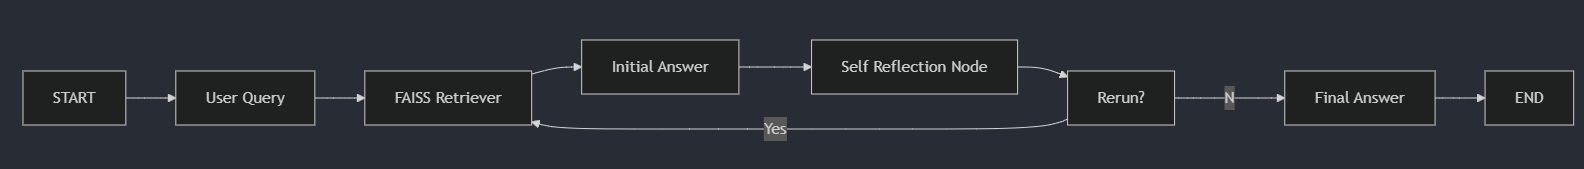

In [8]:
# Dependencies
#!pip install -U langchain langgraph faiss-cpu pymupdf tiktoken groq langchainhub sentence-transformers langchain-community langchain-groq

### Loading and splitting the PDF(s)

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = PyMuPDFLoader("HR-Guide_-Policy-and-Procedure-Template.pdf")
documents = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(documents)

### Embedding and storing it in the vector store (FAISS)

In [7]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore = FAISS.from_documents(chunks, embedding_model)

# retriever from the vector store
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 4})

### Setting up Groq and connecting it to LangChain

In [10]:
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import os
from dotenv import load_dotenv
load_dotenv()


llm = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model="llama3-8b-8192",
    temperature = 0.2
)

prompt_template = PromptTemplate.from_template("""
You are a helpful assistant. Use the following context to answer the question.

Context:
{context}

Question:
{question}

Answer:""")

# building the rag chain
rag_chain = LLMChain(llm=llm, prompt=prompt_template)

### Setting up the LangGraph part

In [11]:
from typing import TypedDict, List

# declaring the AgentState
class AgentState(TypedDict):
    question: str
    docs: List[str]       # retrieved context window
    answer: str           # answer generated
    reflection: str # result after introspection
    retry: bool # yes/no

# defining the node that does the retrieval
def retrieve_node(state: AgentState) -> AgentState:
    docs = retriever.get_relevant_documents(state["question"])
    doc_texts = [doc.page_content for doc in docs]
    return {"docs": doc_texts}

# defining the node that generates answers

def generate_answer_node(state: AgentState) -> AgentState:
    context = "\n\n".join(state.get("docs", []))
    question = state.get("question", "")

    result = rag_chain.invoke({"context": context, "question": question})

    print("generate_answer_node invoked.")
    print("Prompt Sent:\n", result)

    return {"answer": result["text"]}

# defining the self-reflection node (returns a boolean retry, as well as the reflection response)
def reflect_node(state: AgentState) -> AgentState:
    question = state["question"]
    answer = state["answer"]


    reflection_prompt = PromptTemplate.from_template("""
You are an expert assistant. Reflect on whether the answer given below is sufficiently complete and correct
in response to the original question. If the answer is vague, incorrect, or incomplete, suggest retrying.

Question: {question}

Answer: {answer}

Reflection: Do we need to retry? Respond with 'yes' or 'no' and a brief reason.
""")

    reflection_chain = LLMChain(llm=llm, prompt=reflection_prompt)

    response = reflection_chain.invoke({"question": question, "answer": answer})
    reflection_text = response["text"].strip().lower()


    retry = "yes" in reflection_text

    return {"reflection": reflection_text, "retry": retry}

### Building the LangGraph workflow

In [12]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

# adding nodes
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("generate", generate_answer_node)
workflow.add_node("reflect", reflect_node)

# defining the edges
workflow.set_entry_point("retrieve")                   # START node not used, just added this directly instead
workflow.add_edge("retrieve", "generate")              # retrieve -> generate
workflow.add_edge("generate", "reflect")               # generate -> reflect

# conditional logic
def router(state: AgentState):
    return "retry" if state["retry"] else "final"

workflow.add_conditional_edges(
    "reflect",
    router,
    {
        "retry": "retrieve",  # sent back to the retrieval node if the reflection feedback is bad (ie, retry is True)
        "final": END          # ends the graph if the reflection feedback is satisfactory (ie, retry is False)
    }
)


app = workflow.compile()

### Running the Graph (sample question)

In [ ]:
# ask the initial query
user_question = "Can I work remotely from another country for 2 months?"

# starting AgentState
initial_state: AgentState = {
    "question": user_question,
    "docs": [],
    "answer": "",
    "reflection": "",
    "retry": False
}

# run the workflow and collect each step

state = initial_state.copy()

from IPython.display import display, HTML
number_of_steps = 0
for step_output in app.stream(initial_state):
    number_of_steps += 1
    print(f"\n=== STEP {number_of_steps} OUTPUT ===")
    wrapped_output = step_output
    display(HTML(f"<div style='white-space: pre-wrap; font-family: monospace;'>{wrapped_output}</div>"))
    #print(step_output)  # prints whatever was returned in current step

    state.update(step_output)

## Question 1:

In [26]:
# ask the initial query
user_question = "If I respond to an email after 36 hours, is that considered a policy violation?"

# starting AgentState
initial_state: AgentState = {
    "question": user_question,
    "docs": [],
    "answer": "",
    "reflection": "",
    "retry": False
}

state = initial_state.copy()

number_of_steps = 0
for step_output in app.stream(initial_state):
    if "retrieve" in step_output:
        print("\n==============================")
        print("📚 RETRIEVED DOCUMENTS:\n")
        for i, doc in enumerate(step_output["retrieve"]["docs"], 1):
            print(f"Document {i}:\n{doc}\n")

    elif "generate" in step_output:
        answer = step_output["generate"]["answer"]
        print("\n==============================")
        print("🤖 GENERATED ANSWER:\n")
        print(answer.strip(), "\n")

    elif "reflect" in step_output:
        reflection = step_output["reflect"]["reflection"]
        retry = step_output["reflect"]["retry"]
        print("\n==============================")
        print("🧠 SELF-REFLECTION:\n")
        print(reflection.strip(), "\n")
        print("🔁 Retry Decision:", "Yes" if retry else "No")

    else:
        print("\n==============================")
        print("📦 OTHER STEP OUTPUT:\n")
        print(step_output)
    number_of_steps += 1
    state.update(step_output)

print("\n==============================")
print("\n==============================")
print("\n==============================")
print("\nFINAL NUMBER OF REFLECTIONS: " + str(int(number_of_steps/3)))




📚 RETRIEVED DOCUMENTS:

Document 1:
hours missed.
Policies and Procedures Template - Page 24

Document 2:
our information assets and to respect the donors’ rights to privacy and confidentiality.
No information on the internet should be distributed, viewed, copied or saved which is not related to Foundation
business or not in compliance with policies or applicable legislation.
Personal long-distance direct telephone calls from any Foundation telephone are not permitted, except in the
instance of a family emergency. Personal telephone charges will be charged back to the employee upon receipt of

Document 3:
will be unpaid, but will not affect seniority, benefits or the employee’s position. This leave will comply with the
Employment Standards Act. The ten days do not have to be taken consecutively. The employee must inform their
employer as soon as possible if they will need to take any of these days off. The employer has the right to ask for
proof of the emergency.
Personal Leave: A per

## Question 2:

In [25]:
# ask the initial query
user_question = "Can I work remotely from another country for 2 months?"

# starting AgentState
initial_state: AgentState = {
    "question": user_question,
    "docs": [],
    "answer": "",
    "reflection": "",
    "retry": False
}

state = initial_state.copy()

number_of_steps = 0
for step_output in app.stream(initial_state):
    if "retrieve" in step_output:
        print("\n==============================")
        print("📚 RETRIEVED DOCUMENTS:\n")
        for i, doc in enumerate(step_output["retrieve"]["docs"], 1):
            print(f"Document {i}:\n{doc}\n")

    elif "generate" in step_output:
        answer = step_output["generate"]["answer"]
        print("\n==============================")
        print("🤖 GENERATED ANSWER:\n")
        print(answer.strip(), "\n")

    elif "reflect" in step_output:
        reflection = step_output["reflect"]["reflection"]
        retry = step_output["reflect"]["retry"]
        print("\n==============================")
        print("🧠 SELF-REFLECTION:\n")
        print(reflection.strip(), "\n")
        print("🔁 Retry Decision:", "Yes" if retry else "No")

    else:
        print("\n==============================")
        print("📦 OTHER STEP OUTPUT:\n")
        print(step_output)
    number_of_steps += 1
    state.update(step_output)

print("\n==============================")
print("\n==============================")
print("\n==============================")
print("\nFINAL NUMBER OF REFLECTIONS: " + str(int(number_of_steps/3)))

# 8+ reflections, limit reached


📚 RETRIEVED DOCUMENTS:

Document 1:
4 weeks (after completion of the 10th year)
Part-time Employees – Part-time employees will accumulate one day per month in lieu of payment of 4% vacation
pay. The day is equivalent to the normal number of hours regularly worked by the employee.
It is understood all part-time employees are required to take a minimum two (2) weeks of vacation time, either paid
or unpaid, during the vacation period in accordance with the Employment Standards Act (ensure that this clause

Document 2:
our information assets and to respect the donors’ rights to privacy and confidentiality.
No information on the internet should be distributed, viewed, copied or saved which is not related to Foundation
business or not in compliance with policies or applicable legislation.
Personal long-distance direct telephone calls from any Foundation telephone are not permitted, except in the
instance of a family emergency. Personal telephone charges will be charged back to the employee 

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

## Question 3:

In [24]:
# ask the initial query
user_question = "Can I wear casual clothes in internal team meetings?"

# starting AgentState
initial_state: AgentState = {
    "question": user_question,
    "docs": [],
    "answer": "",
    "reflection": "",
    "retry": False
}

state = initial_state.copy()

number_of_steps = 0
for step_output in app.stream(initial_state):
    if "retrieve" in step_output:
        print("\n==============================")
        print("📚 RETRIEVED DOCUMENTS:\n")
        for i, doc in enumerate(step_output["retrieve"]["docs"], 1):
            print(f"Document {i}:\n{doc}\n")

    elif "generate" in step_output:
        answer = step_output["generate"]["answer"]
        print("\n==============================")
        print("🤖 GENERATED ANSWER:\n")
        print(answer.strip(), "\n")

    elif "reflect" in step_output:
        reflection = step_output["reflect"]["reflection"]
        retry = step_output["reflect"]["retry"]
        print("\n==============================")
        print("🧠 SELF-REFLECTION:\n")
        print(reflection.strip(), "\n")
        print("🔁 Retry Decision:", "Yes" if retry else "No")

    else:
        print("\n==============================")
        print("📦 OTHER STEP OUTPUT:\n")
        print(step_output)
    number_of_steps += 1
    state.update(step_output)

print("\n==============================")
print("\n==============================")
print("\n==============================")
print("\nFINAL NUMBER OF REFLECTIONS: " + str(int(number_of_steps/3)))




📚 RETRIEVED DOCUMENTS:

Document 1:
Dress Code
Include this policy if dress code at work matters to your Foundation.
Policy and Procedure Statement
Maintaining a professional, business-like appearance is very important to the success of the Foundation.
Regardless of the employee’s interaction with clients, customers, suppliers, contractors, or volunteers, each
employee projects the reputation of the organization. Part of this impression depends on each employee’s choice
of attire.

Document 2:
of offensive material, physical or sexual assault or taunting about a person’s body, clothing, habits, customs or
mannerisms. Harassment can also include inappropriate or unwelcome comments regarding a person’s physical
characteristics and/or mental health.
Policies and Procedures Template - Page 38

Document 3:
Any and all business activities requiring use of a personal vehicle by the employee must have the prior approval of
the ED/CEO.
Statutory Holidays
Policy and Procedure Statement
The Foun

## Question 4:


In [27]:
# ask the initial query
user_question = "Can I combine paid leave with international remote work?"

# starting AgentState
initial_state: AgentState = {
    "question": user_question,
    "docs": [],
    "answer": "",
    "reflection": "",
    "retry": False
}

state = initial_state.copy()

number_of_steps = 0
for step_output in app.stream(initial_state):
    if "retrieve" in step_output:
        print("\n==============================")
        print("📚 RETRIEVED DOCUMENTS:\n")
        for i, doc in enumerate(step_output["retrieve"]["docs"], 1):
            print(f"Document {i}:\n{doc}\n")

    elif "generate" in step_output:
        answer = step_output["generate"]["answer"]
        print("\n==============================")
        print("🤖 GENERATED ANSWER:\n")
        print(answer.strip(), "\n")

    elif "reflect" in step_output:
        reflection = step_output["reflect"]["reflection"]
        retry = step_output["reflect"]["retry"]
        print("\n==============================")
        print("🧠 SELF-REFLECTION:\n")
        print(reflection.strip(), "\n")
        print("🔁 Retry Decision:", "Yes" if retry else "No")

    else:
        print("\n==============================")
        print("📦 OTHER STEP OUTPUT:\n")
        print(step_output)
    number_of_steps += 1
    state.update(step_output)

print("\n==============================")
print("\n==============================")
print("\n==============================")
print("\nFINAL NUMBER OF REFLECTIONS: " + str(int(number_of_steps/3)))




📚 RETRIEVED DOCUMENTS:

Document 1:
be unpaid. This leave complies with the Employment Standards Code. If an intermittent or reduced leave is
Policies and Procedures Template - Page 23

Document 2:
Part time employees receive General Holiday Pay only if it is a scheduled workday and would be paid for the
average daily wage.
Holiday pay will be calculated at five percent of wages the four weeks immediately preceding the holiday.
Employees will not receive General Holiday Pay if the holiday falls on a day that they are not scheduled to be
working i.e. Saturday, except when July 1 lands on a Sunday then Monday is the designated holiday. This affects or

Document 3:
NEWFOUNDLAND AND LABRADOR
Labour Standards Act
The Labour Standards Act requires all employers
establish conditions of employment that meet at least the
legislated minimum standards in areas such as hours of
work, minimum wage, leave entitlements, termination of
employment, paid public holidays, vacation, etc.
https://www.gov.

## Question 5:

In [28]:
# ask the initial query
user_question = "If I have 5 days of leave remaining, can I take a 10-day vacation and adjust later?"

# starting AgentState
initial_state: AgentState = {
    "question": user_question,
    "docs": [],
    "answer": "",
    "reflection": "",
    "retry": False
}

state = initial_state.copy()

number_of_steps = 0
for step_output in app.stream(initial_state):
    if "retrieve" in step_output:
        print("\n==============================")
        print("📚 RETRIEVED DOCUMENTS:\n")
        for i, doc in enumerate(step_output["retrieve"]["docs"], 1):
            print(f"Document {i}:\n{doc}\n")

    elif "generate" in step_output:
        answer = step_output["generate"]["answer"]
        print("\n==============================")
        print("🤖 GENERATED ANSWER:\n")
        print(answer.strip(), "\n")

    elif "reflect" in step_output:
        reflection = step_output["reflect"]["reflection"]
        retry = step_output["reflect"]["retry"]
        print("\n==============================")
        print("🧠 SELF-REFLECTION:\n")
        print(reflection.strip(), "\n")
        print("🔁 Retry Decision:", "Yes" if retry else "No")

    else:
        print("\n==============================")
        print("📦 OTHER STEP OUTPUT:\n")
        print(step_output)
    number_of_steps += 1
    state.update(step_output)

print("\n==============================")
print("\n==============================")
print("\n==============================")
print("\nFINAL NUMBER OF REFLECTIONS: " + str(int(number_of_steps/3)))




📚 RETRIEVED DOCUMENTS:

Document 1:
will be unpaid, but will not affect seniority, benefits or the employee’s position. This leave will comply with the
Employment Standards Act. The ten days do not have to be taken consecutively. The employee must inform their
employer as soon as possible if they will need to take any of these days off. The employer has the right to ask for
proof of the emergency.
Personal Leave: A personal leave may be granted on a limited basis depending on business needs. This leave will

Document 2:
Although every effort is made by the Foundation to satisfy an employee’s choice of vacation time, legislation
confirms the Foundation is able to request an employee to take time vacation when the Foundation so chooses.
Full-time Employees – The Foundation will provide vacation pay to employees. The Foundation will pay vacation at
four percent for the first 4 years inclusive and this then becomes 6% to full-time employees in their fifth year. When

Document 3:
bus pass 

# SUMMARY
### Question 1: 
**"If I respond to an email after 36 hours, is that considered a policy violation?"**
- Number of reflections required: **1**
- The agent considered the response sufficient on the first try, likely due to the fact that there was no mention specifically about the question in the policy.

**Final Answer:**
>Based on the provided context, there is no mention of a specific policy regarding responding to emails within a certain timeframe. Therefore, responding to an email after 36 hours would not be considered a policy violation. 

### Question 2: 
**"Can I work remotely from another country for 2 months?"**
- Number of reflections required: **8+ (limit reached)**
- The agent wasn't satisfied at all with the responses and reached the final limit and program stopped after retrieving 8 times

**Final Answer:**
> Considering these points, it's likely that working remotely from another country for 2 months might not be allowed or might require special approval from the ED/CEO. I would recommend reaching out to the ED/CEO or HR department to discuss your specific situation and get clarification on the organization's policies regarding remote work and international travel.
> Please note that this is just an interpretation based on the provided context, and it's always best to consult with the organization's HR department or management for specific guidance. 

**Final Reflective Comment**
> yes, i would recommend retrying. the answer is vague and incomplete, and it doesn't provide a clear yes or no answer to the original question. while it attempts to interpret the policy, it doesn't provide a definitive answer and instead suggests that the employee should reach out to the ed/ceo or hr department for clarification. a retry could provide a more direct and clear answer to the question. 

### Question 3: 
**"Can I wear casual clothes in internal team meetings?"**
- Number of reflections required: **1**
- The agent considered the response sufficient on the first try, likely due to the fact that there was a direct reference to the question in the documents.

**Final Answer:**
>According to the provided context, the policy states that maintaining a professional, business-like appearance is important for the success of the Foundation. Although there is no specific mention of internal team meetings, it can be inferred that the expectation of professional attire applies to all interactions, including internal meetings.Therefore, it is likely that casual clothes may not be acceptable in internal team meetings. It's best to dress in a professional and business-like manner to maintain a positive impression and align with the Foundation's expectations.

### Question 4: 
**"Can I combine paid leave with international remote work?"**
- Number of reflections required: **4**
- The agent was quite confused at the start, led to many re-retrievals, but then came to the conclusion that there is no spcific mention in the policy, hence decided to warn the user that whatever it is saying should be checked with the organisation's HR dept.

**Final Answer:**
>Based on the provided context, it does not appear that there is any specific mention of combining paid leave with international remote work. The policies and procedures mentioned only discuss general holiday pay, vacation pay, and leave entitlements, but do not address remote work or international work arrangements.
> However, it's possible that the organization may have additional policies or procedures that address remote work or international work arrangements. I would recommend checking with the organization's HR department or management to determine their specific policies and procedures regarding remote work and leave entitlements.  


### Question 5: 
**"If I have 5 days of leave remaining, can I take a 10-day vacation and adjust later?"**
- Number of reflections required: **5**
- The agent was quite confused at the start, led to many re-retrievals, but then came to some sort of conclusion with a very confident final reflective comment

**Final Answer:**
>Based on the provided context, it seems that the 10 days of leave mentioned are actually part of the Personal Leave, which is a separate category from vacation time. The Personal Leave is intended for emergency situations, and it does not affect seniority, benefits, or the employee's position.
>...
>In summary, you can take your remaining 5 days of Personal Leave, but you would need to use your accrued vacation time to take an additional 5 days off. 

# INFERENCES

- Self-reflection is most valuable when policies aren't explicit or span multiple clauses (eg: combining remote work and leave).
    - Questions with vague, inferred policy implications (like Q2, Q4, Q5) led to multiple reflection loops.
    - **The system worked well in these cases to detect that initial answers were insufficient and attempted to improve them.**
- In highly formal documentation (like HR), the agent tends to give conservative/safe advice rather than hallucinate. The feedback loop helps prevent hallucinations by calling the agent out when something is being made up / isnt explicitly mentioned in the documents.
- Reflection loops are useful, but without better document quality or context filters, looping can become redundant. A future improvement could involve adaptive loop cutoffs based on confidence thresholds.
    - (Q2 hit the reflection limit (8+ attempts) without producing a confident answer.)